In [1]:
import pandas as pd
import pathlib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Import raw data into raw schema
data_dir = pathlib.Path("../data/raw/")
db_path = "../data/sqlite/activity_tracker.db"
mapper_path = pathlib.Path("../data/data_mapper.yml")
excel_path = pathlib.Path("../data/raw/MDE clinical data.xlsx")

In [2]:
def make_unique_columns(cols):
    seen = {}
    result = []
    for col in cols:
        base = col
        if base not in seen:
            seen[base] = 1
            result.append(base)
        else:
            count = seen[base]
            new_col = f"{base}_{count}"
            while new_col in seen:
                count += 1
                new_col = f"{base}_{count}"
            seen[base] = count + 1
            seen[new_col] = 1
            result.append(new_col)
    return result

def sanitize_column(col):
    base = col.split(".")[0]
    # Remove anything in parentheses (and the parentheses themselves)
    base = re.sub(r"\(.*?\)", "", base)
    # Normalize spacing and other characters
    name = "_".join(base.strip().split()).lower()
    # Remove remaining special characters (slashes, dashes, percent signs)
    name = name.replace("/", "").replace("-", "").replace("%", "")
    return name

def stack_visits(df, group_label):
    df = df.rename(columns={"Participant ID": "subject_id"})
    visit_markers = sorted([col for col in df.columns if col.startswith("V") and len(col) == 2 and col[1].isdigit()],
                           key=lambda x: int(x[1:]))
    
    all_visits = []

    for i, marker in enumerate(visit_markers):
        start = df.columns.get_loc(marker) + 1
        end = df.columns.get_loc(visit_markers[i + 1]) if i + 1 < len(visit_markers) else len(df.columns)
        visit_cols = df.columns[start:end].tolist()

        visit_df = df[["subject_id"] + visit_cols].copy()
        cleaned_cols = [sanitize_column(col) for col in visit_cols]
        visit_df.columns = ["subject_id"] + make_unique_columns(cleaned_cols)

        visit_df.insert(1, "group", group_label)
        visit_df.insert(2, "visit_id", int(marker[1:]))

        all_visits.append(visit_df)

    return pd.concat(all_visits, ignore_index=True)

# Load data
xls = pd.ExcelFile(excel_path)

df_visits_control = stack_visits(pd.read_excel(xls, sheet_name=0), "control")
df_visits_exercise = stack_visits(pd.read_excel(xls, sheet_name=1), "exercise")

ffp_cols = ["wt_loss", "weak", "slow", "exhaust", "phys_act"]
for df in [df_visits_control, df_visits_exercise]:
    df["ffp_score"] = df[ffp_cols].sum(axis=1, min_count=len(ffp_cols))
    df["gait"] = 4 / df["walk"].replace(0, pd.NA)

# Combine
df = pd.concat([df_visits_control, df_visits_exercise], ignore_index=True)
df = df.sort_values(by=["subject_id", "visit_id"]).reset_index(drop=True)
df = df[["subject_id", "group", "visit_id", "ffp_status", "ffp_score"]]
df["visit_id"] = df["visit_id"].astype("category")
df["ffp_status"] = df["ffp_status"].apply(lambda x: int(x) if pd.notnull(x) else pd.NA).astype("category")
df["ffp_score"] = df["ffp_score"].astype(float)

In [3]:
control_count = df[df['group'] == 'control']['subject_id'].nunique()
exercise_count = df[df['group'] == 'exercise']['subject_id'].nunique()

print(f"Unique patients in control group: {control_count}")
print(f"Unique patients in exercise group: {exercise_count}")
print(f"Total unique patients: {control_count + exercise_count}")

Unique patients in control group: 47
Unique patients in exercise group: 42
Total unique patients: 89


In [4]:
df

,subject_id,group,visit_id,ffp_status,ffp_score
0,MDE01,control,1,0,4.0
1,MDE01,control,2,0,4.0
2,MDE01,control,3,1,2.0
3,MDE01,control,4,0,4.0
4,MDE01,control,5,0,3.0
...,...,...,...,...,...
440,MDE89,control,1,1,1.0
441,MDE89,control,2,NaN,NaN
442,MDE89,control,3,1,2.0
443,MDE89,control,4,1,1.0


In [5]:
df.query('subject_id == "MDE63"')

,subject_id,group,visit_id,ffp_status,ffp_score
310,MDE63,control,1,0,3.0
311,MDE63,control,2,NaN,NaN
312,MDE63,control,3,NaN,NaN
313,MDE63,control,4,NaN,NaN
314,MDE63,control,5,NaN,NaN


/var/folders/lh/0j8r8lvd4fv6tgr2wz99vbg4f02531/T/ipykernel_5401/1376547147.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_score = df.groupby(['group', 'visit_id'])['ffp_score'].mean().unstack('group')


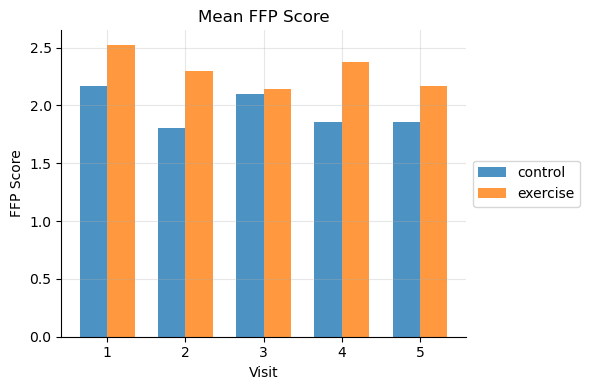

In [6]:
import numpy as np

# Calculate means for ffp_score only
mean_score = df.groupby(['group', 'visit_id'])['ffp_score'].mean().unstack('group')

visit_ids = sorted(df['visit_id'].unique(), key=lambda x: int(x))
groups = ['control', 'exercise']
bar_width = 0.35
x = np.arange(len(visit_ids))

fig, ax = plt.subplots(figsize=(6, 4))

for i, group in enumerate(groups):
    ax.bar(x + i*bar_width, mean_score[group], bar_width, label=group, alpha=0.8)

ax.set_title('Mean FFP Score')
ax.set_xlabel('Visit')
ax.set_ylabel('FFP Score')
ax.set_xticks(x + bar_width/2)
ax.set_xticklabels(visit_ids)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True, alpha=0.3)

plt.tight_layout()
sns.despine()
plt.show()

In [14]:
# Plot using Plotly
ffp_distribution = df.groupby(["visit_id", "ffp_status"]).size().unstack(fill_value=0)

fig = go.Figure()
statuses = [0, 1, 2]
labels = ['Robust (0)', 'Pre-frail (1)', 'Frail (2)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for status, label, color in zip(statuses, labels, colors):
    fig.add_trace(go.Bar(
        x=ffp_distribution.index.astype(str),
        y=ffp_distribution[status],
        name=label,
        text=ffp_distribution[status],
        textposition='inside',
        marker_color=color
    ))

fig.update_layout(
    width=800,      # width in pixels
    height=500, 
    title="FFP Status",
    xaxis_title="Visit",
    yaxis_title="Number of Participants",
    barmode='stack',
    legend_title="FFP Status"
)

fig.show()

/var/folders/lh/0j8r8lvd4fv6tgr2wz99vbg4f02531/T/ipykernel_5401/4263751205.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
df.groupby('visit_id')['ffp_status'].count()
df.groupby('visit_id')['ffp_score'].count()

/var/folders/lh/0j8r8lvd4fv6tgr2wz99vbg4f02531/T/ipykernel_85136/665780957.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('visit_id')['ffp_status'].count()
/var/folders/lh/0j8r8lvd4fv6tgr2wz99vbg4f02531/T/ipykernel_85136/665780957.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('visit_id')['ffp_score'].count()


visit_id
1    89
2    70
3    58
4    68
5    65
Name: ffp_score, dtype: int64

In [ ]:
df.query('subject_id == "MDE84"')

,subject_id,group,visit_id,ffp_status,ffp_score
415,MDE84,control,1,1,2
416,MDE84,control,2,NaN,0
417,MDE84,control,3,2,3
418,MDE84,control,4,1,1
419,MDE84,control,5,1,1


In [ ]:
df.query('subject_id == "MDE84"')

,subject_id,group,visit_id,ffp_status,ffp_score
415,MDE84,control,1,1,2
416,MDE84,control,2,NaN,0
417,MDE84,control,3,2,3
418,MDE84,control,4,1,1
419,MDE84,control,5,1,1


In [ ]:
df.query('subject_id == "MDE84"')

,subject_id,group,visit_id,ffp_status,ffp_score
415,MDE84,control,1,1,2
416,MDE84,control,2,NaN,0
417,MDE84,control,3,2,3
418,MDE84,control,4,1,1
419,MDE84,control,5,1,1


In [13]:
df_visits_all["subject_id"].unique()

array(['MDE01', 'MDE02', 'MDE03', 'MDE04', 'MDE05', 'MDE06', 'MDE07',
       'MDE08', 'MDE09', 'MDE10', 'MDE11', 'MDE12', 'MDE13', 'MDE14',
       'MDE15', 'MDE16', 'MDE17', 'MDE18', 'MDE19', 'MDE20', 'MDE21',
       'MDE22', 'MDE23', 'MDE24', 'MDE25', 'MDE26', 'MDE27', 'MDE28',
       'MDE29', 'MDE30', 'MDE31', 'MDE32', 'MDE33', 'MDE34', 'MDE35',
       'MDE36', 'MDE37', 'MDE38', 'MDE39', 'MDE40', 'MDE41', 'MDE42',
       'MDE43', 'MDE44', 'MDE45', 'MDE46', 'MDE47', 'MDE48', 'MDE49',
       'MDE50', 'MDE51', 'MDE52', 'MDE53', 'MDE54', 'MDE55', 'MDE56',
       'MDE57', 'MDE58', 'MDE59', 'MDE60', 'MDE61', 'MDE62', 'MDE63',
       'MDE64', 'MDE65', 'MDE66', 'MDE67', 'MDE68', 'MDE69', 'MDE70',
       'MDE71', 'MDE72', 'MDE73', 'MDE74', 'MDE75', 'MDE76', 'MDE77',
       'MDE78', 'MDE79', 'MDE80', 'MDE81', 'MDE82', 'MDE83', 'MDE84',
       'MDE85', 'MDE86', 'MDE87', 'MDE88', 'MDE89'], dtype=object)

In [15]:
df_visits_all.query('subject_id == "MDE02"')

,subject_id,group,visit_id,ht,wt,ffp_status,wt_loss,weak,slow,exhaust,...,prep,house,laun,transp,meds,fina,uls,lsns,minicog,moca
5,MDE02,exercise,1,65.0,191.6,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,54.0,23.0,3.0,NaN
6,MDE02,exercise,2,64.5,184.4,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,55.0,41.0,NaN,NaN
7,MDE02,exercise,3,64.5,181.8,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,53.0,40.0,NaN,NaN
8,MDE02,exercise,4,64.5,175.2,1.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,49.0,40.0,NaN,NaN
9,MDE02,exercise,5,64.5,178.5,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,53.0,44.0,5.0,18.0


In [19]:
visits_per_patient = df_visits_all.groupby('subject_id')['visit_id'].nunique()
print(visits_per_patient)

subject_id
MDE01    5
MDE02    5
MDE03    5
MDE04    5
MDE05    5
        ..
MDE85    5
MDE86    5
MDE87    5
MDE88    5
MDE89    5
Name: visit_id, Length: 89, dtype: int64
